# AdaBoost
Boost is an ensemble algorithm that attempts to create a strong classifier from a number of weak classifiers. 

## prepare data

In [1]:
import pandas as pd
data = pd.read_csv('data.txt', delimiter=' ') 
data

,X1,X2,Y
0,3.647540,2.996793,0
1,2.612664,4.459458,0
2,2.363360,1.506982,0
3,4.932600,1.299009,0
4,3.776155,3.157451,0
5,8.673961,2.122873,1
6,5.861599,0.003513,1
7,8.984677,1.768161,1
8,7.467381,0.187046,1
9,4.436284,0.862698,1


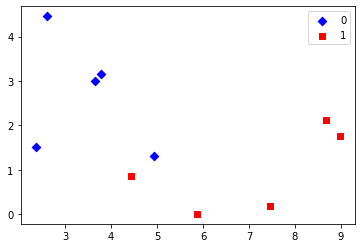

In [2]:
import os
os.environ['MPLCONFIGDIR'] = "/tmp/"
import matplotlib.pyplot as plt

plt.scatter(data.iloc[:5,0], data.iloc[:5,1], c='blue', marker='D', label='0')
plt.scatter(data.iloc[5:,0], data.iloc[5:,1], c='red',  marker='s', label='1')
plt.legend()

## train
Three weak models are going to be trained one after the other. Adaboost uses decision stump as the internal model. <br>
As a tutorial, points will be split manually.

<span style="color:orange; font-size:1.5em;">**prediction**</span><br>
- if $X_1 <= thres$, label = 0
- if $X_1 > thres$,  label = 1

<span style="color:orange; font-size:1.5em;">**error**</span><br>
- if prediction == Y, error = 0
- if prediction != Y, error = 1

<span style="color:orange; font-size:1.5em;">**Misclassification Rate**</span><br>
$$\mathrm{MisclassificationRate} = \frac{\sum_{i=1}^n w_i \times \mathrm{error}}{\sum_{i=1}^n w}$$

$$\mathrm{stage} = ln(\frac{1-\mathrm{MisRate}}{\mathrm{MisRate}})$$

<span style="color:orange; font-size:1.5em;">**Update Weights**</span><br>
$$\mathrm{weight} = \mathrm{weight} \times e^{\mathrm{stage}\times\mathrm{werror}}$$

### Model\#1
Lets assume the poings will be split at a fixed threshold, which is the max of X1 in LEFT group.

In [3]:
thres1 = 4.932600453
n = len(data)

In [4]:
from adaboost import decision_stump
import numpy as np
weight_init = 1/n * np.ones(len(data))
model1, stage1 = decision_stump(thres = thres1, thres_var = 'X1', 
                                mode = 'less', data = data, 
                                weight = weight_init).train()
model1

,Y,prediction,error,weight,werror
0,0,0,0,0.100000,0.0
1,0,0,0,0.100000,0.0
2,0,0,0,0.100000,0.0
3,0,0,0,0.100000,0.0
4,0,0,0,0.100000,0.0
5,1,1,0,0.100000,0.0
6,1,1,0,0.100000,0.0
7,1,1,0,0.100000,0.0
8,1,1,0,0.100000,0.0
9,1,0,1,0.124573,0.1


the weight of mis-classified item becomes larger, so that next model will pay more attention on this item

### Model\#2
This weak model will make a split on the X2 variable at a fixed threshold

In [5]:
thres2 = 2.122873405
model2, stage2 = decision_stump(thres = thres2, thres_var = 'X2',
                                mode = 'large', data = data,
                                weight = model1['weight']).train()
model2

,Y,prediction,error,weight,werror
0,0,0,0,0.100000,0.0
1,0,0,0,0.100000,0.0
2,0,1,1,0.115218,0.1
3,0,1,1,0.115218,0.1
4,0,0,0,0.100000,0.0
5,1,1,0,0.100000,0.0
6,1,1,0,0.100000,0.0
7,1,1,0,0.100000,0.0
8,1,1,0,0.100000,0.0
9,1,1,0,0.124573,0.0


### Model\#3

In [6]:
thres3 = 0.862698005
model3, stage3 = decision_stump(thres = thres3, thres_var = 'X2',
                                mode = 'large', data = data,
                                weight = model2['weight']).train()
model3

,Y,prediction,error,weight,werror
0,0,0,0,0.100000,0.0
1,0,0,0,0.100000,0.0
2,0,0,0,0.115218,0.0
3,0,0,0,0.115218,0.0
4,0,0,0,0.100000,0.0
5,1,0,1,0.115636,0.1
6,1,1,0,0.100000,0.0
7,1,0,1,0.115636,0.1
8,1,1,0,0.100000,0.0
9,1,1,0,0.124573,0.0


## prediction with AdaBoost model

In [7]:
print(stage1, stage2, stage3)

2.197224577336219 1.4165484239922632 1.4527944804404969


In [8]:
def model_prediction(num):
    tmp = np.zeros(n)
    for i in range(n):
        exec(f'tmp[i] = stage{num} * (-1 if model{num}.loc[i, "prediction"] == 0 else 1)')
    return tmp

In [9]:
# a new data frame to save results
pred_df = pd.DataFrame()
pred_df['X1'] = data['X1']
pred_df['X2'] = data['X2']

# prediction of individual models
for k in range(1, 4):
    pred_df[f'model{k}'] = model_prediction(k)
    
# ensemble three models
pred_df['sum'] = pred_df[['model1', 'model2', 'model3']].sum(axis=1)

# prediction
tmp = []
for i in range(n):
    tmp.append(0 if pred_df.loc[i, 'sum'] < 0 else 1)
pred_df['prediction'] = tmp
pred_df['Y'] = data['Y']

# error
tmp = []
for i in range(n):
    tmp.append(0 if pred_df.loc[i, 'prediction'] == pred_df.loc[i, 'Y'] else 1)
pred_df['error'] = tmp

acc = 1 - sum(pred_df['error'])/len(data)
print(f'accuracy = {acc*100:.0f}%')

accuracy = 100%


In [10]:
pred_df

,X1,X2,model1,model2,model3,sum,prediction,Y,error
0,3.647540,2.996793,-2.197225,-1.416548,-1.452794,-5.066567,0,0,0
1,2.612664,4.459458,-2.197225,-1.416548,-1.452794,-5.066567,0,0,0
2,2.363360,1.506982,-2.197225,1.416548,-1.452794,-2.233471,0,0,0
3,4.932600,1.299009,-2.197225,1.416548,-1.452794,-2.233471,0,0,0
4,3.776155,3.157451,-2.197225,-1.416548,-1.452794,-5.066567,0,0,0
5,8.673961,2.122873,2.197225,1.416548,-1.452794,2.160979,1,1,0
6,5.861599,0.003513,2.197225,1.416548,1.452794,5.066567,1,1,0
7,8.984677,1.768161,2.197225,1.416548,-1.452794,2.160979,1,1,0
8,7.467381,0.187046,2.197225,1.416548,1.452794,5.066567,1,1,0
9,4.436284,0.862698,-2.197225,1.416548,1.452794,0.672118,1,1,0
